In [1]:
## read features:
import numpy as np
import pandas as pd

base_dir = "C:/Users/Xin/Dropbox/BrainImaging_ML/"
# base_dir = "/home/xin/Dropbox/BrainImaging_ML/"

data_dir = base_dir + "data"
atlas_dir = base_dir + "Atlas_label"
work_dir= base_dir + "multidimensional_age_prediction/"

# # ransac/huber with spm8 vbm features:
# figure_dir = work_dir + "figures_robustreg_behav_hc2"
# result_dir = work_dir + "result_robustreg_behav_hc2"

# # ransac/huber with spm8 vbm features:
# figure_dir = work_dir + "figures_robustreg_behav_hc2_center_age"
# result_dir = work_dir + "result_robustreg_behav_hc2_center_age"

# # ransac/huber with spm8 vbm features:
# figure_dir = work_dir + "figures_robustreg_behav_hc2_stdz_age"
# result_dir = work_dir + "result_robustreg_behav_hc2_stdz_age"

# ransac/huber with spm8 vbm features:
figure_dir = work_dir + "figures01_robustreg_behav_hc2_stdz_age_reverse_fa"
result_dir = work_dir + "out01_robustreg_behav_hc2_stdz_age_reverse_fa"
hc_column = 'mental_hc2'

# figure_dir = work_dir + "figures_robustreg_behav_hc3_stdz_age_reverse_fa"
# result_dir = work_dir + "result_robustreg_behav_hc3_stdz_age_reverse_fa"
# hc_column = 'mental_hc3'

behav_feature = pd.read_csv(result_dir+'/out01_behav_feature_hc.csv', index_col = 0)

feature_beta_df = pd.read_csv(result_dir + '/out01_robust_regression_coefs_empty.csv', index_col = 0)
feature_p_df = pd.read_csv(result_dir + '/out01_robust_regression_pvalue_empty.csv', index_col = 0)


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from scipy import stats

import statistics

num_subjects = behav_feature.shape[0]
num_features = len(behav_feature.columns)-3

# alpha = np.power(10, np.linspace(-1, 3, num = 50))
# ridge_cv = RidgeCV(alphas=alpha, cv = 5)

lr = LinearRegression()

resi_thresh = [1, 1.5, 2]
n_resi_thresh = len(resi_thresh)

for i_thresh in range(n_resi_thresh):

    # as robust scaler scales the data by IQR, we set the residualthreshold to 1.5
    robust_reg = RANSACRegressor(base_estimator = lr, min_samples=.9, residual_threshold = resi_thresh[i_thresh],
                                 stop_probability=.95, stop_n_inliers = num_subjects*.9)

    # robust_reg = HuberRegressor(epsilon=1.35, max_iter=100, alpha=0.0001, warm_start=False, fit_intercept=True, tol=1e-05)

    num_features = len(behav_feature.columns)-3

    

    for i_feature in range(num_features):
        print(i_feature)
        print(feature_beta_df.index[i_feature])

        gender = behav_feature.iloc[:,1].values
        chro_age = behav_feature.iloc[:,2].values

        feature = behav_feature.iloc[:,3+i_feature].values
        
#     # remove outliers:
#     X = np.transpose(np.vstack((chro_age, feature, gender)))
#     remove_idx = find_outlier(X)
    
#         nan_idx = np.isnan(feature)
#         feature = feature[~nan_idx]
#         gender = gender[~nan_idx]
#         chro_age = chro_age[~nan_idx]

        X = np.transpose(np.vstack((chro_age, chro_age**2, gender, chro_age*gender, (chro_age**2)*gender)))
        y = feature

    ############################################## ridge CV:########################################

    #     # remove outliers based on the residuals of ridge regression:
    #     clf = ridge_cv.fit(X, y)
    #     residuals = y-clf.predict(X)
    #     remove_idx = find_outlier(residuals)

    #     # scale y with outlier removed:
    #     scaler.fit(y[~remove_idx].reshape(-1,1))
    #     y = scaler.transform(y.reshape(-1,1))

    #     clf = ridge_cv.fit(X[~remove_idx,:], y[~remove_idx].flatten())
    #     r2 = clf.score(X[~remove_idx,:], y[~remove_idx]) 
    #     feature_beta_df.iloc[i_feature,1:] = np.hstack((clf.coef_, r2))

    ############################################ robust regression: #################################

        # scale the feature with inliers:
    #     robust_reg.fit(X, y)
    #     inlier_mask = np.logical_not(robust_reg.outliers_)
    #     inlier_mask = robust_reg.inlier_mask_
    #     scaler.fit(y[inlier_mask].reshape(-1,1))
    #     y = scaler.transform(y.reshape(-1,1)).flatten()

        lr_all = lr.fit(X, y)
        # robust regression:
        robust_reg.fit(X, y)

    #     inlier_mask = np.logical_not(robust_reg.outliers_)
        inlier_mask = robust_reg.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        coefs = robust_reg.estimator_.coef_

        # fit linear regression inliers and get the p-values of coefficients:
        lr.fit(X[inlier_mask,:], y[inlier_mask])
        params = np.append(lr.intercept_,lr.coef_)
        #predictions = lr.predict(X[inlier_mask,:])
        predictions = lr.predict(X)

        # calculate p values:
    #     newX = np.append(np.ones((len(X[inlier_mask,:]),1)), X[inlier_mask,:], axis=1)
    #     MSE = (sum((y[inlier_mask]-predictions)**2))/(len(newX)-len(newX[0]))

        newX = np.append(np.ones((len(X),1)), X, axis=1)
        MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))


        var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
        sd_b = np.sqrt(var_b)
        ts_b = params/ sd_b
        p_values =np.array([2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b])

        # compare the coefs of lr (with inliers) and ransac, which should be same
        print(coefs)
        print(lr.coef_)

        # set non-significant coefs to 0:
        # coefs[p_values[1:]>0.05]=0 
        # np.place(coefs, p_values[1:]>.05, 0)

        r2 = robust_reg.score(X, y) 
        r2_median = 1- (statistics.median(abs(predictions-y))/statistics.median(abs(y-statistics.mean(y))))**2

        feature_p_df.iloc[i_feature,1:] = p_values[1:]
        feature_beta_df.iloc[i_feature,1:] = np.hstack((coefs, r2, r2_median))
    #     feature_beta_df.iloc[i_feature,1:] = np.hstack((robust_reg.coef_, r2))

    ############################################# make regression plots:#############################
        #plot_age = np.arange(5,26, step = 1)
        plot_age = np.arange(min(X[:,0])-1, max(X[:,0])+1, step = 1)
        plot_gender = np.ones(len(plot_age))

        plot_x_male = np.transpose(np.vstack((plot_age, plot_age**2, plot_gender, 
                                              plot_age*plot_gender, (plot_age**2)*plot_gender)))

        plot_x_female = np.transpose(np.vstack((plot_age, plot_age**2, -plot_gender,
                                                plot_age*-plot_gender, (plot_age**2)*-plot_gender)))

        y_curve_male = lr_all.predict(plot_x_male)
        y_curve_female = lr_all.predict(plot_x_female)

        y_curve_male = lr_all.predict(plot_x_male)
        y_curve_female = lr_all.predict(plot_x_female)

        y_curve_male_ransac = robust_reg.predict(plot_x_male)
        y_curve_female_ransac = robust_reg.predict(plot_x_female)

        y_curve_male_ransac = robust_reg.predict(plot_x_male)
        y_curve_female_ransac = robust_reg.predict(plot_x_female)

        label = "$R^2$ = %.3f" % r2

        fig = plt.figure()
        ax = fig.add_subplot(111)    

        ax.plot(plot_age, y_curve_female, 'r--')
        ax.plot(plot_age, y_curve_male, 'b--')

    #     ax.plot(plot_age, y_curve_female_ransac, 'r-')
    #     ax.plot(plot_age, y_curve_male_ransac, 'b-')

        idx = np.logical_and(gender==-1, outlier_mask)
        ax.plot(chro_age[idx]+np.random.random(sum(idx))*.3, y[idx], 
                'r+', markersize = 2.5)

        idx = np.logical_and(gender==-1, inlier_mask)
        ax.plot(chro_age[idx]+np.random.random(sum(idx))*.3, y[idx], 
                'ro', label='females', markersize = 2.5)

        idx = np.logical_and(gender==1, outlier_mask)
        ax.plot(chro_age[idx]+np.random.random(sum(idx))*.3, y[idx], 
                'b+', markersize = 2.5)

        idx = np.logical_and(gender==1, inlier_mask)
        ax.plot(chro_age[idx]+np.random.random(sum(idx))*.3, y[idx], 
                'bo', label='males', markersize = 2.5)

        ax.text(min(X[:,0]+1), max(y), label, fontsize = 10)
        y_label = feature_beta_df.index[i_feature]+' ('+ feature_beta_df.iloc[i_feature, 0]+')'    
        if len(y_label)>20:
            y_label = y_label[:20]

        ax.set_ylabel(y_label)

        ax.legend()
        fig.savefig(figure_dir+'/figure_scatter_age_feature_thresh' + str(i_thresh) + '_' +
                   feature_beta_df.iloc[i_feature, 0] + str(i_feature) + '.jpg', format = 'jpg', dpi=300)
        plt.close('all')
        
    feature_beta_df.to_csv(result_dir+'/out01_behav_feature_beta_ransac_lr_thresh' + str(i_thresh) + '.csv')
    feature_p_df.to_csv(result_dir+'/out01_behav_feature_p_ransac_lr_thresh' + str(i_thresh) + '.csv')

        
############################################## sigmoid fit:########################################
#     try:
#         feature_beta_df.iloc[i_feature,1:] = sigmoid_fit(chro_age, gender, feature)

#         x = np.linspace(6, 23, num=30)
#         y_fit_m = sigmoid2(x, feature_beta_df.iloc[i_feature,1],feature_beta_df.iloc[i_feature,2],
#                            feature_beta_df.iloc[i_feature,3],feature_beta_df.iloc[i_feature,4])

#         y_fit_f = sigmoid2(x, feature_beta_df.iloc[i_feature,5],feature_beta_df.iloc[i_feature,6],
#                            feature_beta_df.iloc[i_feature,7],feature_beta_df.iloc[i_feature,8])

#         fig = plt.figure()
#         ax = fig.add_subplot(111)    
#         ax.plot(x, y_fit_m, 'b--', label='male')
#         ax.plot(x, y_fit_f, 'r--', label='female')

#         male_idx = subject_info_feature.iloc[:,1]==1
#         female_idx = subject_info_feature.iloc[:,1]!=1

#         ax.plot(subject_info_feature.loc[male_idx].iloc[:,2],
#                 subject_info_feature.loc[male_idx].iloc[:,i_feature+3], 'bo')

#         ax.plot(subject_info_feature.loc[female_idx].iloc[:,2],
#                 subject_info_feature.loc[female_idx].iloc[:,i_feature+3],'ro')

#         ax.legend()
#         fig.savefig(figure_dir+'/figure_scatter_age_feature_sigmoid2fit_' +
#                    feature_beta_df.iloc[i_feature, 0] + str(i_feature) + '.jpg', format = 'jpg', dpi=300)
#         plt.close('all')

#         print(feature_beta_df.iloc[i_feature,1:])
#     except:
#         fig = plt.figure()
#         ax = fig.add_subplot(111)    

#         male_idx = subject_info_feature.iloc[:,1]==1
#         female_idx = subject_info_feature.iloc[:,1]!=1

#         ax.plot(subject_info_feature.loc[male_idx].iloc[:,2],
#                 subject_info_feature.loc[male_idx].iloc[:,i_feature+3], 'bo')

#         ax.plot(subject_info_feature.loc[female_idx].iloc[:,2],
#                 subject_info_feature.loc[female_idx].iloc[:,i_feature+3],'ro')

#         ax.legend()
#         fig.savefig(figure_dir+'/figure_scatter_age_feature_sigmoid2fit_fail_' +
#                    feature_beta_df.iloc[i_feature, 0] + str(i_feature) + '.jpg', format = 'jpg', dpi=300)
#         plt.close('all')
    
    

0
Left Precentral
[-0.41408489  0.05961368  0.21155151  0.05179919 -0.04206436]
[-0.41408489  0.05961368  0.21155151  0.05179919 -0.04206436]
1
Right Precentral
[-0.3126666   0.14508377  0.11220503 -0.06107593 -0.01660457]
[-0.3126666   0.14508377  0.11220503 -0.06107593 -0.01660457]
2
Left Superior Frontal
[-0.39162571  0.05681274  0.20540414 -0.00354624 -0.10044275]
[-0.39162571  0.05681274  0.20540414 -0.00354624 -0.10044275]
3
Right Superior Frontal
[-0.22609891  0.06559507  0.20007858 -0.02516724 -0.01520716]
[-0.22609891  0.06559507  0.20007858 -0.02516724 -0.01520716]
4
Left Superior Frontal Orbital
[-0.41208114  0.19844204 -0.03718407 -0.02760187  0.03679888]
[-0.41208114  0.19844204 -0.03718407 -0.02760187  0.03679888]
5
Right Superior Frontal Orbital
[-0.39515158  0.04983267  0.02368153 -0.0794591   0.01529563]
[-0.39515158  0.04983267  0.02368153 -0.0794591   0.01529563]
6
Left Middle Frontal
[-0.41044846  0.09290417  0.19672085 -0.03285045 -0.02415186]
[-0.41044846  0.09290

56
Left Postcentral
[-0.47189017  0.09542353  0.16049957 -0.0422502  -0.08016269]
[-0.47189017  0.09542353  0.16049957 -0.0422502  -0.08016269]
57
Right Postcentral
[-0.40795322  0.11574344  0.08281319 -0.13347229  0.01976513]
[-0.40795322  0.11574344  0.08281319 -0.13347229  0.01976513]
58
Left Superior Parietal
[-0.32738308  0.07194901  0.04586152  0.0128267  -0.01783509]
[-0.32738308  0.07194901  0.04586152  0.0128267  -0.01783509]
59
Right Superior Parietal
[-0.31607607  0.10109126 -0.10419213  0.00578761  0.13149779]
[-0.31607607  0.10109126 -0.10419213  0.00578761  0.13149779]
60
Left Inferior Parietal
[-0.5510161   0.17951746  0.04634521 -0.01727979 -0.05549596]
[-0.5510161   0.17951746  0.04634521 -0.01727979 -0.05549596]
61
Right Inferior Parietal
[-0.50549594  0.10915209 -0.00273363 -0.02519759  0.03785161]
[-0.50549594  0.10915209 -0.00273363 -0.02519759  0.03785161]
62
Left Supramarginal
[-0.56216433  0.1820767  -0.02618524  0.04058773  0.12795134]
[-0.56216433  0.1820767  

113
Vermis_8
[-0.24897498  0.04066897 -0.06419189 -0.03135839  0.0208458 ]
[-0.24897498  0.04066897 -0.06419189 -0.03135839  0.0208458 ]
114
Vermis_9
[-0.12145053  0.00320828 -0.12838641  0.01691106 -0.03800908]
[-0.12145053  0.00320828 -0.12838641  0.01691106 -0.03800908]
115
Vermis_10
[-0.11605584 -0.13221361 -0.0083908  -0.03749891 -0.04423465]
[-0.11605584 -0.13221361 -0.0083908  -0.03749891 -0.04423465]
116
 Middle.cerebellar.peduncle(label)
[-0.14242048  0.07422943 -0.12878126  0.04929922 -0.04733485]
[-0.14242048  0.07422943 -0.12878126  0.04929922 -0.04733485]
117
 Pontine.crossing.tract.(a.part.of.MCP)(label)
[ 0.20402562 -0.07248651  0.02562079  0.11477812 -0.09437816]
[ 0.20402562 -0.07248651  0.02562079  0.11477812 -0.09437816]
118
 Genu.of.corpus.callosum(label)
[-0.32968702  0.25670581 -0.00097967  0.05324799 -0.08561265]
[-0.32968702  0.25670581 -0.00097967  0.05324799 -0.08561265]
119
 Body.of.corpus.callosum(label)
[-0.30470088  0.16122724  0.04043183  0.11110905 -0.07

161
 Inferior.fronto-occipital.fasciculus.L(label)
[-0.23737436  0.18233575  0.02434107 -0.07350238 -0.10385168]
[-0.23737436  0.18233575  0.02434107 -0.07350238 -0.10385168]
162
 Uncinate.fasciculus.R(label)
[-0.21619294  0.09155968  0.10254542 -0.14009582 -0.1400458 ]
[-0.21619294  0.09155968  0.10254542 -0.14009582 -0.1400458 ]
163
 Uncinate.fasciculus.L(label)
[-0.06986889  0.16031316  0.11809499 -0.07788125 -0.20977333]
[-0.06986889  0.16031316  0.11809499 -0.07788125 -0.20977333]
164
 Tapetum.R(label)
[-0.21596343  0.14877502  0.21670117 -0.04925969 -0.21517982]
[-0.21596343  0.14877502  0.21670117 -0.04925969 -0.21517982]
165
 Tapetum.L(label)
[-1.27929791e-01  2.03665765e-01  1.60818975e-01 -9.19947567e-05
 -1.70034911e-01]
[-1.27929791e-01  2.03665765e-01  1.60818975e-01 -9.19947567e-05
 -1.70034911e-01]
166
 Anterior.thalamic.radiation.L(tract)
[-0.27964326  0.17301414 -0.12302215  0.04786319 -0.00902477]
[-0.27964326  0.17301414 -0.12302215  0.04786319 -0.00902477]
167
 Ante

27
Right Rectus
[-0.37324539  0.09127688 -0.06352173 -0.16318185  0.05151832]
[-0.37324539  0.09127688 -0.06352173 -0.16318185  0.05151832]
28
Left Insula
[-0.44082406  0.0914649   0.07013101 -0.0678997   0.01126129]
[-0.44082406  0.0914649   0.07013101 -0.0678997   0.01126129]
29
Right Insula
[-0.42529835  0.07916446  0.05099528 -0.07349675 -0.03545596]
[-0.42529835  0.07916446  0.05099528 -0.07349675 -0.03545596]
30
Left Anterior Cingulum
[-0.26323387  0.03053395  0.02318613 -0.01206396  0.09044552]
[-0.26323387  0.03053395  0.02318613 -0.01206396  0.09044552]
31
Right Anterior Cingulum
[-0.29168447  0.01715655 -0.00325056 -0.01176367  0.10120833]
[-0.29168447  0.01715655 -0.00325056 -0.01176367  0.10120833]
32
Left Middle Cingulum
[-0.37383925  0.13256609  0.11250971  0.05210928  0.07774805]
[-0.37383925  0.13256609  0.11250971  0.05210928  0.07774805]
33
Right Middle Cingulum
[-0.41632482  0.07351926  0.19631674  0.01492171  0.04218591]
[-0.41632482  0.07351926  0.19631674  0.01492

[-0.26572908  0.02597368  0.17551324  0.02931406 -0.05226729]
[-0.26572908  0.02597368  0.17551324  0.02931406 -0.05226729]
83
Right Superior Temporal Pole
[-0.3005573   0.05315582  0.15150415  0.07512487 -0.02372383]
[-0.3005573   0.05315582  0.15150415  0.07512487 -0.02372383]
84
Left Middle Temporal
[-0.41930423  0.1545978   0.09207918  0.01750984  0.04667785]
[-0.41930423  0.1545978   0.09207918  0.01750984  0.04667785]
85
Right Middle Temporal
[-0.41553419  0.1363471   0.1485143  -0.02295921  0.01914442]
[-0.41553419  0.1363471   0.1485143  -0.02295921  0.01914442]
86
Left Middle Temporal Pole
[-0.12937054 -0.04289665  0.1678379   0.03451108  0.03015807]
[-0.12937054 -0.04289665  0.1678379   0.03451108  0.03015807]
87
Right Middle Temporal Pole
[-0.22368768  0.05141912 -0.04463783  0.10536952  0.23093781]
[-0.22368768  0.05141912 -0.04463783  0.10536952  0.23093781]
88
Left Inferior Temporal
[-0.34357474  0.01728362  0.19306796  0.01483719 -0.05207342]
[-0.34357474  0.01728362  0.

137
 Retrolenticular.part.of.internal.capsule.L(label)
[-0.11916819  0.17348392  0.10331199  0.03487825 -0.13062735]
[-0.11916819  0.17348392  0.10331199  0.03487825 -0.13062735]
138
 Anterior.corona.radiata.R(label)
[-0.24176256  0.16781721  0.11667611 -0.04272475 -0.16941974]
[-0.24176256  0.16781721  0.11667611 -0.04272475 -0.16941974]
139
 Anterior.corona.radiata.L(label)
[-0.21463988  0.11760135 -0.05779909  0.05214042 -0.06796965]
[-0.21463988  0.11760135 -0.05779909  0.05214042 -0.06796965]
140
 Superior.corona.radiata.R(label)
[-0.37535786  0.04094318  0.03383694 -0.0062276  -0.07136686]
[-0.37535786  0.04094318  0.03383694 -0.0062276  -0.07136686]
141
 Superior.corona.radiata.L(label)
[-0.32314432  0.06226108  0.05205563  0.04690269 -0.0538438 ]
[-0.32314432  0.06226108  0.05205563  0.04690269 -0.0538438 ]
142
 Posterior.corona.radiata.R(label)
[-0.20598155  0.12651874 -0.09072641 -0.10029626 -0.013034  ]
[-0.20598155  0.12651874 -0.09072641 -0.10029626 -0.013034  ]
143
 Poste

185
 Superior.longitudinal.fasciculus.(temporal.part).R(tract)
[-0.08887494  0.06499809  0.11627024 -0.06205677 -0.08735493]
[-0.08887494  0.06499809  0.11627024 -0.06205677 -0.08735493]
0
Left Precentral
[-0.42975018  0.07511785  0.14661975 -0.02706744  0.01064239]
[-0.42975018  0.07511785  0.14661975 -0.02706744  0.01064239]
1
Right Precentral
[-0.33517895  0.12731767  0.1041096  -0.0700441   0.01004331]
[-0.33517895  0.12731767  0.1041096  -0.0700441   0.01004331]
2
Left Superior Frontal
[-0.38530314  0.06071052  0.21731819  0.01893901 -0.09406523]
[-0.38530314  0.06071052  0.21731819  0.01893901 -0.09406523]
3
Right Superior Frontal
[-0.22930795  0.0685844   0.15610555 -0.02733307 -0.02310655]
[-0.22930795  0.0685844   0.15610555 -0.02733307 -0.02310655]
4
Left Superior Frontal Orbital
[-0.41321643  0.16836882 -0.06766442 -0.05353152  0.08382419]
[-0.41321643  0.16836882 -0.06766442 -0.05353152  0.08382419]
5
Right Superior Frontal Orbital
[-0.40095474  0.06561133  0.03470691 -0.05

55
Right Fusiform
[-0.31350509  0.07400471  0.1342401  -0.02735557 -0.005604  ]
[-0.31350509  0.07400471  0.1342401  -0.02735557 -0.005604  ]
56
Left Postcentral
[-0.47978684  0.13159812  0.11721539 -0.07838631 -0.03212878]
[-0.47978684  0.13159812  0.11721539 -0.07838631 -0.03212878]
57
Right Postcentral
[-0.37676654  0.13080775  0.04156942 -0.07067633 -0.00054242]
[-0.37676654  0.13080775  0.04156942 -0.07067633 -0.00054242]
58
Left Superior Parietal
[-0.32062525  0.06225882  0.07742698  0.01637095 -0.04936598]
[-0.32062525  0.06225882  0.07742698  0.01637095 -0.04936598]
59
Right Superior Parietal
[-0.31658078  0.1062409  -0.14638872  0.0209721   0.1645075 ]
[-0.31658078  0.1062409  -0.14638872  0.0209721   0.1645075 ]
60
Left Inferior Parietal
[-4.70073704e-01  1.50126506e-01  4.79995006e-03 -4.17157506e-02
 -4.26560404e-05]
[-4.70073704e-01  1.50126506e-01  4.79995006e-03 -4.17157506e-02
 -4.26560404e-05]
61
Right Inferior Parietal
[-0.48269132  0.12541356 -0.00159055 -0.03764577 

111
Vermis_6
[-0.31877168  0.07086289  0.02190802 -0.06871034  0.06305802]
[-0.31877168  0.07086289  0.02190802 -0.06871034  0.06305802]
112
Vermis_7
[-0.48813624  0.08698707 -0.03443131 -0.15042226 -0.0182233 ]
[-0.48813624  0.08698707 -0.03443131 -0.15042226 -0.0182233 ]
113
Vermis_8
[-0.24652356  0.05762162 -0.023602   -0.0306586   0.03773104]
[-0.24652356  0.05762162 -0.023602   -0.0306586   0.03773104]
114
Vermis_9
[-0.10660317  0.00600409 -0.03868407  0.06382668 -0.07354001]
[-0.10660317  0.00600409 -0.03868407  0.06382668 -0.07354001]
115
Vermis_10
[-0.12604241 -0.11189767  0.00758064  0.00928961 -0.03612292]
[-0.12604241 -0.11189767  0.00758064  0.00928961 -0.03612292]
116
 Middle.cerebellar.peduncle(label)
[-0.13238992  0.09562471 -0.04486882  0.02936646 -0.09067597]
[-0.13238992  0.09562471 -0.04486882  0.02936646 -0.09067597]
117
 Pontine.crossing.tract.(a.part.of.MCP)(label)
[ 0.12640347 -0.02784749  0.00440291 -0.00761574 -0.09070669]
[ 0.12640347 -0.02784749  0.00440291 -

[-0.15363189  0.14793663  0.03756298  0.04028499 -0.05858538]
[-0.15363189  0.14793663  0.03756298  0.04028499 -0.05858538]
160
 Inferior.fronto-occipital.fasciculus.R(label)
[-0.26386779  0.23804824 -0.01320189 -0.05826476 -0.03847181]
[-0.26386779  0.23804824 -0.01320189 -0.05826476 -0.03847181]
161
 Inferior.fronto-occipital.fasciculus.L(label)
[-0.23382782  0.17804232  0.03883202 -0.05465671 -0.09530017]
[-0.23382782  0.17804232  0.03883202 -0.05465671 -0.09530017]
162
 Uncinate.fasciculus.R(label)
[-0.1575396   0.12089768  0.08063156 -0.14624763 -0.11684091]
[-0.1575396   0.12089768  0.08063156 -0.14624763 -0.11684091]
163
 Uncinate.fasciculus.L(label)
[-0.1634954   0.0978093   0.21093601 -0.12844338 -0.23436809]
[-0.1634954   0.0978093   0.21093601 -0.12844338 -0.23436809]
164
 Tapetum.R(label)
[-0.17951988  0.14262121  0.15884552 -0.03924267 -0.16918561]
[-0.17951988  0.14262121  0.15884552 -0.03924267 -0.16918561]
165
 Tapetum.L(label)
[-0.13171319  0.13368352  0.13714706  0.01

In [3]:
# scatter plot of coefficients with different outlier threshold:

feature_beta_df1 = pd.read_csv(result_dir+'/out01_behav_feature_beta_ransac_lr_thresh1.csv')
feature_beta_df1 = pd.melt(feature_beta_df1, id_vars  = ['Unnamed: 0', 'modality'])
feature_beta_df2 = pd.read_csv(result_dir+'/out01_behav_feature_beta_ransac_lr_thresh2.csv')
feature_beta_df2 = pd.melt(feature_beta_df2, id_vars  = ['Unnamed: 0', 'modality'])

feature_beta_df_all = feature_beta_df1.merge(feature_beta_df2, on = ['Unnamed: 0', 'modality', 'variable'])
feature_beta_df_all

,Unnamed: 0,modality,variable,value_x,value_y
0,Left Precentral,gmv,age,-0.429750,-0.429750
1,Right Precentral,gmv,age,-0.358167,-0.335179
2,Left Superior Frontal,gmv,age,-0.385477,-0.385303
3,Right Superior Frontal,gmv,age,-0.231689,-0.229308
4,Left Superior Frontal Orbital,gmv,age,-0.440276,-0.413216
...,...,...,...,...,...
1311,Superior.longitudinal.fasciculus.R(tract),tract_fa,RsquareMedian,0.235848,0.231100
1312,Uncinate.fasciculus.L(tract),tract_fa,RsquareMedian,0.254508,0.215236
1313,Uncinate.fasciculus.R(tract),tract_fa,RsquareMedian,0.383648,0.352851
1314,Superior.longitudinal.fasciculus.(temporal.pa...,tract_fa,RsquareMedian,0.094568,-0.027941


C:\Users\Xin\Anaconda3\lib\site-packages\seaborn\regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


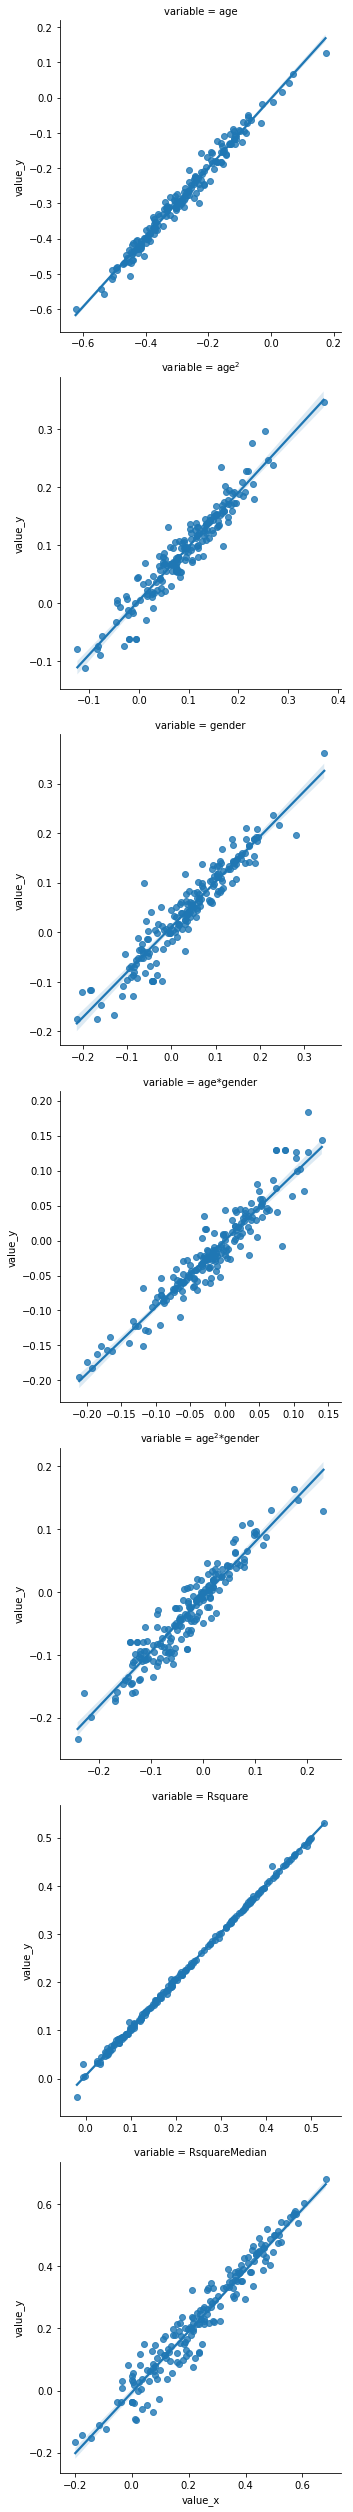

In [4]:
import seaborn as sns

sns.lmplot(x = 'value_x', y = 'value_y', data = feature_beta_df_all, 
           row = 'variable', order = 1, sharex = False, sharey = False, size = 5
          )